In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

In [2]:
###Get dataset
mnist_train = pd.read_csv('Data/digit-recognizer/train.csv').astype(np.float32)
mnist_test = pd.read_csv('Data/digit-recognizer/test.csv').astype(np.float32)

In [3]:
###Split dataset
y_train = mnist_train[['label']][:30000]
x_train = mnist_train[['pixel' + str(idx) for idx in range(784)]][:30000]

y_dev = mnist_train[['label']][30000:42000]
x_dev = mnist_train[['pixel' + str(idx) for idx in range(784)]][30000:42000]

x_test = mnist_test[['pixel' + str(idx) for idx in range(784)]]

In [4]:
###Rescale dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_dev = scaler.transform(x_dev)
x_test = scaler.transform(x_test)

print(x_train.shape, y_train.shape, x_dev.shape, y_dev.shape, x_test.shape)

(30000, 784) (30000, 1) (12000, 784) (12000, 1) (28000, 784)


In [5]:
###Prepare for training: labels in sparse representation shape (-1)
ys = y_train.astype(int).values.reshape(-1)
xs = x_train
ys_one_hot = tf.one_hot(ys, 10)

ys_test = y_dev.astype(int).values.reshape(-1)
xs_test = x_dev

In [33]:
###Minimizer taken from tf library. Actually, this code is redundant and can be simplified
def _minimize(strategy, tape, optimizer, loss, trainable_variables):
    """Minimizes loss for one step by updating `trainable_variables`.
    This is roughly equivalent to
    ```python
    gradients = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    ```
    However, this function also applies gradient clipping and loss scaling if the
    optimizer is a LossScaleOptimizer.
    Args:
    strategy: `tf.distribute.Strategy`.
    tape: A gradient tape. The loss must have been computed under this tape.
    optimizer: The optimizer used to minimize the loss.
    loss: The loss tensor.
    trainable_variables: The variables that will be updated in order to minimize
    the loss.
    """

    with tape:
        if isinstance(optimizer, lso.LossScaleOptimizer):
            loss = optimizer.get_scaled_loss(loss)

    gradients = tape.gradient(loss, trainable_variables)

    # Whether to aggregate gradients outside of optimizer. This requires support
    # of the optimizer and doesn't work with ParameterServerStrategy and
    # CentralStroageStrategy.
    aggregate_grads_outside_optimizer = (
        optimizer._HAS_AGGREGATE_GRAD and  # pylint: disable=protected-access
        not isinstance(strategy.extended,
                       parameter_server_strategy.ParameterServerStrategyExtended))

    if aggregate_grads_outside_optimizer:
        # We aggregate gradients before unscaling them, in case a subclass of
        # LossScaleOptimizer all-reduces in fp16. All-reducing in fp16 can only be
        # done on scaled gradients, not unscaled gradients, for numeric stability.
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
                                                       trainable_variables))
    if isinstance(optimizer, lso.LossScaleOptimizer):
        gradients = optimizer.get_unscaled_gradients(gradients)
    gradients = optimizer._clip_gradients(gradients)  # pylint: disable=protected-access
    if trainable_variables:
        if aggregate_grads_outside_optimizer:
            optimizer.apply_gradients(
                zip(gradients, trainable_variables),
                experimental_aggregate_gradients=False)
        else:
            optimizer.apply_gradients(zip(gradients, trainable_variables))

###Model build in low level way
class Model(tf.keras.Model):
    def __init__(self, cl_coeff, dropout_rate = 0.1, variance_epsilon=1e-3, stddev = 0.1, bias = 0.1):
        super(Model, self).__init__()
        
        ###Model is Lenet++ taken from 'A Discriminative Feature Learning Approachfor Deep Face Recognition'
        
        #Input shape 28*28*1
        input_shape = (-1,28,28,1)
        
        ###Weights initialisation for convolution layers should be sqrt(2/k*k*c) as in Kaiming He's, 'Delving Deep into Rectifiers...')
        ###because using PReLU as activation function for Conv layers
        conv_init = tf.keras.initializers.he_normal()
        #conv_init = tf.random_normal_initializer(mean=0.0, stddev=stddev, seed=None)
        
        ###Biases initialisation for convolution layers. Should be zeroes.
        conv_bias_init = 'zeros'
        #conv_bias_init = tf.constant_initializer(bias)

        ###Model layers
        #1,2: (5/32)/1,2 x 2 PReLU
        #3: MaxPool 2/2,0
        #4,5: (5/64)/1,2 x 2 PReLU
        #6: MaxPool 2/2,0
        #7,8: (5/128)/1,2 x 2 PReLU
        #9: MaxPool 2/2,0 + Dropout
        #10: FC2 - feature vector
        #11: FC10 - output
        self.conv1_1 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, input_shape=input_shape[1:])
        self.conv1_1_pr = self.get_conv_act(alpha=0.5)
        self.conv1_2 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv1_2_pr = self.get_conv_act(alpha=0.5)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        self.conv2_1 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_1_pr = self.get_conv_act(alpha=0.3)
        self.conv2_2 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_2_pr = self.get_conv_act(alpha=0.3)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        ###For last two convolution layers added L1L2 regularizer
        self.conv3_1 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_1_pr = self.get_conv_act(alpha=0.2)
        self.conv3_2 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_2_pr = self.get_conv_act(alpha=0.2)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        self.pool3_drop = tf.keras.layers.Dropout(dropout_rate)
        
        self.feat = tf.keras.layers.Dense(2, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.out = tf.keras.layers.Dense(10)
        
        ###Batch normalisation is not used
        #self.bn_conv1_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv2_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv3_2 = tf.keras.layers.BatchNormalization()
        #self.bn_feat = tf.keras.layers.BatchNormalization()
        #self.bn_out = tf.keras.layers.BatchNormalization()
        
        #Make centers tf.constants - because we update them manually
        self.centers = tf.constant(tf.zeros([10,2], dtype=tf.float32), name="centers")
        self.cl_coeff = cl_coeff
        self.dropout_rate = dropout_rate
        self.variance_epsilon = variance_epsilon
    
    def get_conv_act(self, alpha = 0.2):
        #return tf.keras.layers.LeakyReLU(alpha=alpha)
        return tf.keras.layers.PReLU(alpha_initializer = tf.constant_initializer(alpha))
    
    def get_regularizer(self,l1=0.01,l2=0.01):
        return tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    #def get_features(self, x, training=False):
    def __call__(self, x, training=False):
        x_reshaped = tf.reshape(x, [-1,28,28,1])
        h_conv1_1 = self.conv1_1(x_reshaped)
        h_conv1_1_pr = self.conv1_1_pr(h_conv1_1)
        h_conv1_2 = self.conv1_2(h_conv1_1_pr)
        h_conv1_2_pr = self.conv1_2_pr(h_conv1_2)
        h_pool1 = self.pool1(h_conv1_2_pr)
        #h_pool1_bn = self.bn_conv1_2(h_pool1, training = training)
        
        tf.print(tf.nn.moments(h_conv1_2,axes=[0,1,2,3])[1])
        
        h_conv2_1 = self.conv2_1(h_pool1)
        h_conv2_1_pr = self.conv2_1_pr(h_conv2_1)
        h_conv2_2 = self.conv2_2(h_conv2_1_pr)
        h_conv2_2_pr = self.conv2_2_pr(h_conv2_2)
        h_pool2 = self.pool2(h_conv2_2_pr)
        #h_pool2_bn = self.bn_conv2_2(h_pool2, training = training)
        
        tf.print(tf.nn.moments(h_conv2_2,axes=[0,1,2,3])[1])
        
        h_conv3_1 = self.conv3_1(h_pool2)
        h_conv3_1_pr = self.conv3_1_pr(h_conv3_1)
        h_conv3_2 = self.conv3_2(h_conv3_1_pr)
        h_conv3_2_pr = self.conv3_2_pr(h_conv3_2)
        h_pool3 = self.pool3(h_conv3_2_pr)

        tf.print(tf.nn.moments(h_conv3_2,axes=[0,1,2,3])[1])
        
        h_pool3_flt = tf.reshape(h_pool3, [-1,h_pool3.shape[1]*h_pool3.shape[2]*h_pool3.shape[3]])  #tf.reshape(h_pool3, self.get_flat_shape(h_pool3))
        #h_pool3_bn = self.bn_conv3_2(h_pool3_flt, training = training)
        
        h_pool3_flt_drop = self.pool3_drop(h_pool3_flt,training = training)

        h_feat = self.feat(h_pool3_flt_drop)
        
        tf.print(tf.nn.moments(h_feat,axes=[0,1])[1])
        
        #features = self.bn_out(features, training = training)
        y_out = self.out(h_feat)
        
        #In case of library losses use softmax output
        return y_out, h_feat   #tf.nn.softmax(y_out)
    
    def get_center_loss(self, features, labels):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(tf.stop_gradient(self.centers), labels)
        center_loss = tf.reduce_sum(input_tensor=(features - centers_batch) ** 2, axis=[1])
        return center_loss

    def centers_update(self, features, labels, alpha):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - features

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)
        diff = alpha * diff
        
        label_reshaped = tf.reshape(labels,[-1,1])
        
        self.centers = tf.tensor_scatter_nd_sub(self.centers, label_reshaped, diff)
        
    def get_losses(self, x, y, training=False):
        y_pred, h_features = self(x, training=training)
        return self._get_losses(y, y_pred, h_features)

    def _get_losses(self, y, y_pred, h_features):
        y_one_hot = tf.one_hot(y, 10)
        center_loss = self.get_center_loss(h_features, y)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_one_hot), logits=y_pred)
        #!!!!!!!!!!!!!!!!TEMPRORARY REMOVED. HERE WITHOUT CENTERL OSS!!!!!!!!!!!!!!
        loss = tf.reduce_mean(input_tensor=softmax_loss) # + self.cl_coeff * center_loss
        return loss, softmax_loss, center_loss
    
    def get_accuracy(self, x, y):
        y_pred, _ = self(x, training=False)
        result = tf.argmax(input=y_pred,axis=1)
        ground_truth = tf.reshape(y, [-1])
        correct_prediction = tf.equal(result, ground_truth)
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def get_centers(self):
        return self.centers
    
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with backprop.GradientTape() as tape:
            y_pred, h_features = self(x, training=True)
            ###Calculate centerloss but don't include it in loss function
            loss, softmax_loss, center_loss = self._get_losses(y, y_pred, h_features) 
            #Default loss cant be used...
            #loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
        
        ###Simple optimiser, not used.
        #trainable_variables = self.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
                  self.trainable_variables)
        
        ###Update center loss    
        self.centers_update(h_features, y, 0.5) 
        
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        
        #trace output
        tf.print({m.name: m.result() for m in self.metrics})
        
        return {m.name: m.result() for m in self.metrics}
    
#Not used here, because can't implement center loss
class Softmax_and_center_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=softmax_loss ) 
        return loss


In [34]:
###Train model with dropout 0.15, batch size 256, 10 epochs. Train/test accuracy = 0.9868/0.9715833
model = Model(0.0, dropout_rate = 0.15, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
bunch_len = 256
model.compile(opt, loss=model_loss, metrics=["accuracy"])

dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

for i in range(10):
    #loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    #tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    #tf.print('Full loss: ', loss)
    #tf.print('Softmax loss: ', softmax_loss)
    #tf.print('Center loss: ', tf.reduce_mean(center_loss))
    #tf.print('Centers: ', model.get_centers())
    for batch in dataset_batches:    
        model.train_step(batch)
print("====================================================")
print("Final train Accuracy:", model.get_accuracy(xs, ys))        
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))     

1.72498274
3.42376018
4.01502228
4.97124815
{'accuracy': 0.1171875}
1.61245978
3.20543814
4.96476412
69.3072433
{'accuracy': 0.099609375}
1.57165205
2.46892691
1.06273186
8.17241573
{'accuracy': 0.115885414}
1.37504542
2.36417747
0.583263099
5.8322916
{'accuracy': 0.115234375}
1.24995506
2.33411217
0.443258911
1.17478895
{'accuracy': 0.127343744}
1.28706646
2.4659524
0.453934193
3.19172049
{'accuracy': 0.134114578}
1.27209246
2.30139852
0.401994914
1.79878902
{'accuracy': 0.135044649}
1.31021643
2.15998507
0.375290185
1.24798882
{'accuracy': 0.136230469}
1.0569303
1.78823948
0.309783429
2.05459023
{'accuracy': 0.140625}
1.09110808
1.7115556
0.290531754
2.35881
{'accuracy': 0.145312503}
0.996466339
1.46009719
0.256050825
2.0729208
{'accuracy': 0.151633516}
2.13975811
3.07512498
0.537655175
3.76300526
{'accuracy': 0.159830734}
1.12027299
1.3839072
0.299042284
2.95224833
{'accuracy': 0.16947116}
1.33946419
1.67037845
0.390931606
4.13382483
{'accuracy': 0.172433034}
1.35105228
1.67355025
0

327.397827
{'accuracy': 0.41654548}
2.49281168
5.86255074
5.58980036
292.290405
{'accuracy': 0.417868376}
2.61037731
5.7731
5.48218155
263.913391
{'accuracy': 0.419689298}
2.5131278
5.62287521
5.02643681
224.515289
{'accuracy': 0.421415687}
2.42107558
5.55171061
5.09119511
253.865234
{'accuracy': 0.422858059}
2.47285748
5.47306776
5.6090889
431.633942
{'accuracy': 0.424498975}
2.61756802
5.80382872
5.32624578
374.426849
{'accuracy': 0.425924748}
2.77023435
6.06891918
6.05583239
453.116821
{'accuracy': 0.426703691}
2.23707271
5.14312792
5.86327267
558.977783
{'accuracy': 0.428120345}
2.32349277
5.23167944
5.45669365
453.347321
{'accuracy': 0.429330468}
2.17598486
5.02414227
5.85493326
529.201843
{'accuracy': 0.430917859}
4.10040045
8.90176105
6.51285362
367.523376
{'accuracy': 0.432027102}
2.44279861
5.58169413
5.74322367
451.897461
{'accuracy': 0.433629394}
2.79257393
6.30662
6.08595848
439.128906
{'accuracy': 0.43487969}
2.71248698
6.14538527
6.36098051
512.361633
{'accuracy': 0.43643

2526.0293
{'accuracy': 0.595848739}
4.10534525
16.3956966
31.9958801
2218.31982
{'accuracy': 0.597074091}
4.01317167
16.2559719
30.3760643
1957.76465
{'accuracy': 0.598223627}
3.89452124
15.9425898
30.5330181
1898.41064
{'accuracy': 0.599559426}
3.93354321
15.3361969
30.6276131
2138.13721
{'accuracy': 0.600835264}
4.22010756
16.2732029
29.302021
1890.3501
{'accuracy': 0.602230072}
4.45258045
16.768856
32.2219543
1886.84863
{'accuracy': 0.603452146}
3.60129356
14.2194653
29.8552551
2210.81812
{'accuracy': 0.604648173}
3.7545011
14.4634962
28.614727
1912.44409
{'accuracy': 0.605946302}
3.52686286
13.746109
30.2816334
2284.56152
{'accuracy': 0.607249737}
6.45913649
21.5487862
32.8168449
1957.0697
{'accuracy': 0.608384073}
3.97186875
14.8526011
31.8855324
2401.56763
{'accuracy': 0.609682918}
4.51686239
16.0085526
32.1417274
2245.25708
{'accuracy': 0.61093986}
4.32932711
15.2601147
31.5621071
2266.54834
{'accuracy': 0.612139702}
5.14575148
17.7200546
32.997963
2191.7373
{'accuracy': 0.61340

23.7369213
64.893631
5277.5459
{'accuracy': 0.70648247}
4.9221344
23.6928
62.8572731
4814.31396
{'accuracy': 0.707165122}
4.80005169
23.3455429
63.8945198
4775.1543
{'accuracy': 0.707822084}
4.84327793
22.3268948
62.6949043
4979.75928
{'accuracy': 0.708442569}
5.22925854
23.8152943
58.842556
4160.10303
{'accuracy': 0.709157646}
5.47354889
23.9485855
63.017662
3776.65283
{'accuracy': 0.709781826}
4.41610718
20.2038059
57.8377304
4199.10938
{'accuracy': 0.710413396}
4.61403084
20.3669548
54.4435081
3500.95605
{'accuracy': 0.711073875}
4.28985739
19.042942
53.3017044
3442.07764
{'accuracy': 0.711763084}
8.03088379
29.6230869
57.8690643
3097.86621
{'accuracy': 0.712351739}
4.80583477
20.1155052
53.4110527
3509.41846
{'accuracy': 0.712990761}
5.5067997
21.7951241
52.3255653
3128.53906
{'accuracy': 0.713658333}
5.23018026
20.3827801
49.163002
3185.69043
{'accuracy': 0.714215696}
6.28649664
23.9656677
51.583725
3237.59521
{'accuracy': 0.714812517}
4.84801579
19.7492332
49.5552254
2873.98389
{

6649.71582
{'accuracy': 0.768888831}
5.48615646
30.4672432
100.822617
6731.24707
{'accuracy': 0.769277692}
5.53467798
29.4171238
102.899231
7607.0957
{'accuracy': 0.769673169}
5.97210026
31.1714497
96.216835
6470.52148
{'accuracy': 0.770083427}
6.24021673
31.4459152
102.553612
5823.03809
{'accuracy': 0.770442784}
5.03744125
26.7028942
91.287529
5677.93311
{'accuracy': 0.770841539}
5.26825428
27.0821877
88.2174377
4862.47559
{'accuracy': 0.771222234}
4.90498495
25.4819279
86.3218689
4445.78
{'accuracy': 0.771634}
9.23125935
40.3926926
96.9281921
4097.48145
{'accuracy': 0.771979034}
5.51335239
27.4106426
87.35495
4241.13184
{'accuracy': 0.772363126}
6.34758282
29.6676598
85.3551178
3656.1167
{'accuracy': 0.772778034}
6.02739286
27.5545635
79.0043945
3444.96265
{'accuracy': 0.773126602}
7.30807686
32.3422203
79.3819427
3226.40869
{'accuracy': 0.773465693}
5.61455154
26.347332
74.9318085
3049.93335
{'accuracy': 0.773827493}
7.41638041
31.7613506
82.9316406
3190.68384
{'accuracy': 0.7741878

6.23154926
36.5838737
115.822807
7271.93115
{'accuracy': 0.808916688}
6.72813368
39.4142075
118.248665
7530.16211
{'accuracy': 0.809206}
7.01886797
40.4640732
130.535614
7649.99951
{'accuracy': 0.809454918}
5.64773512
34.5493507
122.918785
8620.77832
{'accuracy': 0.809696376}
5.89657
35.1333351
123.960609
8157.34863
{'accuracy': 0.809956729}
5.46686029
33.4737473
128.164673
8920.58301
{'accuracy': 0.810242355}
10.2777176
49.3846397
135.623352
8192.23535
{'accuracy': 0.810481369}
6.08498955
34.8538742
128.485535
9239.44434
{'accuracy': 0.810765147}
6.9892664
36.8028908
127.533958
8387.89551
{'accuracy': 0.811048031}
6.60113764
33.7411118
114.568581
7535.19092
{'accuracy': 0.811297476}
7.98740387
38.211483
112.522591
6346.47119
{'accuracy': 0.8115201}
6.07023907
31.0527515
104.93634
4535.02539
{'accuracy': 0.811748445}
8.05500603
37.1364784
119.420486
3982.94629
{'accuracy': 0.811969638}
6.62717867
31.6178741
107.464394
3556.68628
{'accuracy': 0.812190056}
7.50067902
35.5329933
115.93040

{'accuracy': 0.835553825}
7.65287
45.4880638
159.673218
9177.43164
{'accuracy': 0.835730135}
6.13709736
39.131752
150.787476
10957.0566
{'accuracy': 0.835911453}
6.42028761
40.0006
148.008743
9615.33789
{'accuracy': 0.836081266}
5.93068266
38.1703835
152.27919
11160.5654
{'accuracy': 0.836283505}
11.3654938
56.8046722
159.904434
10103.9023
{'accuracy': 0.836463273}
6.6257596
39.9717751
154.744965
11676.7441
{'accuracy': 0.836658895}
7.70206261
43.0542183
160.031967
11403.8184
{'accuracy': 0.836864889}
7.28636646
39.7016449
146.183273
10311.4219
{'accuracy': 0.837037623}
8.8991251
45.3578262
147.456757
10139.8496
{'accuracy': 0.837226212}
6.70631361
37.7698555
140.932297
8993.0332
{'accuracy': 0.837430596}
8.94828796
44.9967346
155.205505
8485.60352
{'accuracy': 0.837618113}
7.33203363
38.8828
141.790619
7772.62793
{'accuracy': 0.837815881}
8.29394817
44.0543671
150.957626
7333.76465
{'accuracy': 0.837980747}
5.90040112
34.1708298
135.500717
6602.91
{'accuracy': 0.838161349}
7.8974309
3

{'accuracy': 0.855518579}
6.67657232
41.2140121
173.877411
11726.7598
{'accuracy': 0.855655074}
6.98515892
42.3458214
167.051376
9585.91699
{'accuracy': 0.855805397}
6.43801212
40.5182915
165.810226
9715.79297
{'accuracy': 0.855950654}
12.3363638
59.6895218
176.794403
8513.3291
{'accuracy': 0.856090903}
7.18440104
43.4244118
166.213989
10041.9707
{'accuracy': 0.856230795}
8.34239864
46.5815163
168.297729
9868.22754
{'accuracy': 0.856365621}
7.91357374
43.869648
157.367157
9255.17285
{'accuracy': 0.856500208}
9.65664768
50.7084846
166.661499
10014.209
{'accuracy': 0.856629729}
7.36201954
43.4765434
168.098297
10042.5479
{'accuracy': 0.856782317}
9.82330227
51.3634
185.415146
10735.042
{'accuracy': 0.856929839}
8.07823563
44.556282
171.807983
10518.4922
{'accuracy': 0.857063055}
9.13795853
49.6632042
188.81163
10734.4551
{'accuracy': 0.857205272}
6.51119137
40.3166885
172.250671
10125.3467
{'accuracy': 0.857347131}
8.7436018
46.7554169
171.851
9021.50098
{'accuracy': 0.857484043}
6.96433

{'accuracy': 0.871099949}
7.11147261
48.6181183
214.009094
13599.0117
{'accuracy': 0.871215343}
6.55848408
46.9407692
220.562698
14467.749
{'accuracy': 0.871334672}
12.6538706
69.5380096
242.069839
13448.8848
{'accuracy': 0.87144959}
7.33204937
49.3278465
223.976517
14879.3457
{'accuracy': 0.871568441}
8.57168484
53.2041817
228.301865
14219.084
{'accuracy': 0.871695161}
8.14798737
49.9560242
212.613159
13052.9951
{'accuracy': 0.87180531}
9.96495056
57.9161682
221.718948
13284.6016
{'accuracy': 0.871915162}
7.61525249
49.5205078
220.30838
13118.9482
{'accuracy': 0.872016609}
10.1049738
57.9956207
240.360336
13079.6055
{'accuracy': 0.872142375}
8.32459736
50.983696
219.60527
12628.9697
{'accuracy': 0.872239292}
9.41896439
57.4427299
241.073349
12663.1875
{'accuracy': 0.872340083}
6.70499134
45.9148788
217.239639
12410.5986
{'accuracy': 0.872448802}
9.01331139
52.8343239
205.837128
10003.5527
{'accuracy': 0.872545123}
7.23778534
45.7981873
198.84436
9812.26074
{'accuracy': 0.872653425}
7.

6.85864
51.7456741
243.464279
14013.4727
{'accuracy': 0.883584559}
13.3496962
76.1571884
270.612244
13525.0742
{'accuracy': 0.883679032}
7.65493965
55.833622
254.125992
15756.6113
{'accuracy': 0.883773327}
8.93445396
60.5627899
257.5625
15148.457
{'accuracy': 0.883874774}
8.44504929
56.1431274
234.832153
13233.5879
{'accuracy': 0.883972406}
10.3534021
65.6853
247.134766
14146.1074
{'accuracy': 0.884066164}
7.85921574
55.5169
245.901886
14293.7246
{'accuracy': 0.884159744}
10.5091505
65.2730484
260.031769
14215.1162
{'accuracy': 0.884245932}
8.68925095
57.2331581
241.065323
14697.6992
{'accuracy': 0.884310067}
9.8718
64.1101532
258.864197
14978.6895
{'accuracy': 0.884410441}
7.01606035
51.04002
229.395386
13598.0977
{'accuracy': 0.884503365}
9.42974758
59.0581665
227.813812
12685.2578
{'accuracy': 0.884596109}
7.51900673
51.5973091
225.523041
13648.8369
{'accuracy': 0.884688735}
8.17692757
55.3098679
243.165314
14422.3496
{'accuracy': 0.884788394}
8.52571106
55.7038727
235.985718
14107.

In [35]:
#Get predictions and features for test dataframe
y_pred_logits, features_tf = model(xs_test)
features = np.array(features_tf)
y_pred_label = np.array(tf.argmax(y_pred_logits, axis=1))

13.6410837
68.1959457
239.723892
15117.0029


In [36]:
###Show centers coords
np.array(model.centers)

array([[  59.543243, -140.46205 ],
       [ 186.7626  ,   68.796135],
       [ -63.026142,  144.9672  ],
       [  33.29442 ,  217.0255  ],
       [ -69.58429 ,   35.623234],
       [ 130.86513 , -100.595726],
       [ 201.12239 ,  -28.841066],
       [ 117.11163 ,  124.41429 ],
       [-103.223045,   -9.589776],
       [ -23.742973,  -78.14319 ]], dtype=float32)

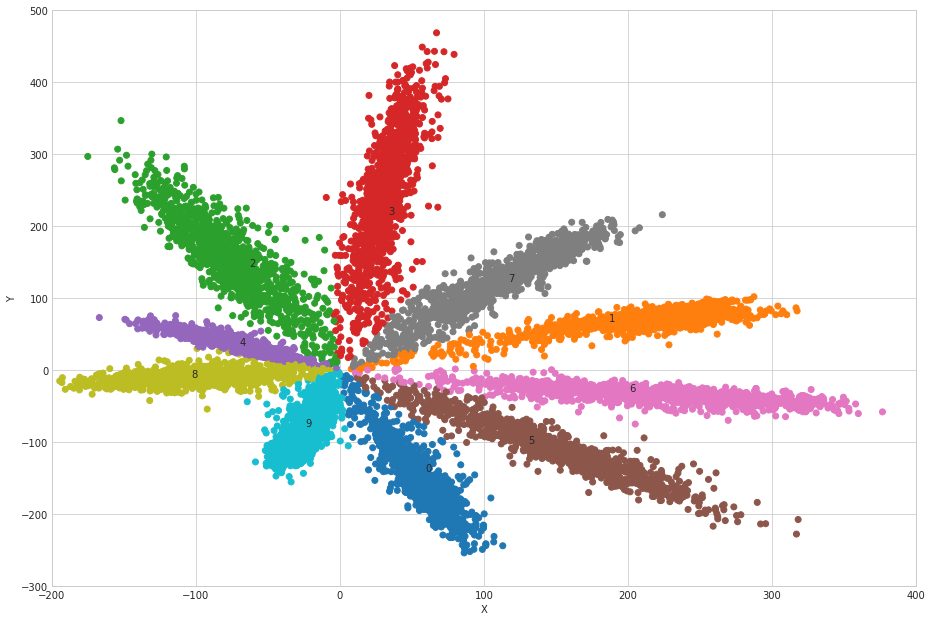

In [39]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)



class Plot_Report(object):
    def __init__(self, centers):
        self.fig = plt.figure()
        self.ax = self.fig.add_axes([-2,-2,2,2])
        self.centers = centers
        self.center_names = ["0","1","2","3","4","5","6","7","8","9"]
        self.cmap = colors.ListedColormap(['#1f77b4', '#ff7f0e', 
                              '#2ca02c', '#d62728', 
                              '#9467bd', '#8c564b', 
                              '#e377c2', '#7f7f7f', 
                              '#bcbd22', '#17becf'])
        #self.cmap = discrete_cmap(10, 'cubehelix')
        
    def plot_data(self,x,y,c):
        self.ax.scatter(x,y, c=c , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        
    def plot_centers(self):
        self.ax.scatter(self.centers[:,0],self.centers[:,1], c=[i for i in range(10)] , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.centers[i,0], self.centers[i,1]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        
    def show(self):
        plt.xlim(-200, 400)
        plt.ylim(-300, 500)
        plt.show()
        
myplot = Plot_Report(np.array(model.centers))

myplot.plot_data(features[:,0],features[:,1],y_pred_label)
myplot.plot_centers()
myplot.show()